# Построение моделей для предсказания показателей регионов

## Описание работы

В данной работе предпринимается попытка создания моделей, позволяющих предсказывать:
* Контроль над ходом госзакупок (доля отмененных конкурсов в общем количестве), %;
* Общественное обсуждение законопроектов в Интернете (да - 1, нет - 0);
* Количество зарегистрированных организаций ТОС на 10 тысяч человек, штук.

Для предсказания используются следующие индикаторы:
* Институционные факторы:
    1. elections - Конкурентность выборов (да - 1, нет - 0);
    2. parliament - Уровень парламентской конкуренции, %;
    3. executive - Уровень конкуренции при формировании исполнительной власти, %;
    4. citizens_election - Включенность граждан в избирательный процесс, %;
    5. citizens_org - Участие граждан в деятельности общественных организаций, %;
* Инфраструктурные факторы:
    1. internet_all - Количество абонентов сети интернет, тысяч;
    2. internet_mobile - Количество абонентов мобильного интернета на 100 человек, единиц;
    3. internet_pc - Число персональных компьютеров на 100 человек, штук;
    4. org_access - Организации, связанные с бизнесом и использующие интернет (от общего числа обследованных организаций), %;
    5. org_site - Организации, связанные с бизнесом и имеющие веб-сайт (от общего числа обследованных организаций), %;
    6. org_pc - Число персональных компьютеров на 100 работников в бизнесе, штук;
    7. edm - Системы электронного документооборота (от общего числа обследованных организаций), %;
    8. edm_external - Автоматический обмен данными между своими и внешними информационными системами (от общего числа обследованных организаций), %;
    9. authority_access - Организации, имеющие отношение в органам власти и использующие интернет (от общего числа обследованных организаций), %;
    10. public_services - Доступность госуслуг, в том числе и за счет сокращения сроков предоставления (да - 1, нет - 0);
    11. open_data - Наличие инфраструктуры открытых данных, в том числе государственных (да - 1, нет - 0);
    12. open_election - Открытость процесса выборов (да - 1, нет - 0);
* Ресурсные факторы:
    1. average_edu - Доля населения со средним образованием, %;
    2. high_edu - Доля населения с высшим образованием, %;
    3. degree - Доля населения, имеющего ученые степени, %;
    4. ict - Доля специалистов в области ИКТ, %;
    5. grp - ВРП на душу населения, рублей;
    6. income - Среднедушевые доходы населения, рублей;
    7. po - Объем использования программного обеспечения, %;
    8. invest - Удельный вес инвестиций в основной капитал в ВВП, %;
    9. venture - Доступность венчурного капитала, штук;
    10. pc - Количество персональных компьютеров на 100 человек, штук;
    11. nt - Затраты организаций на сетевые технологии, миллионов рублей; 
    12. ict_grp - Удельный вес затрат на ИКТ в ВРП, %.
    
Необходимо отметить, что в работе использовался достаточно скудный набор данных, из-за чего модели могут существенно отличаться при новом, более обширном анализе. С учетом этого, большинство шагов автоматизировано, что позволяет пересчитывать параметры моделей без внесения изменений в код.

## Код с комментариями

Импортируем используемые библиотеки.

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sb
from scipy import stats
from sklearn import preprocessing
from IPython.display import display
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import linear_model
from sklearn import ensemble
import matplotlib.pyplot as plt

Настраиваем графики для отображения в теле блокнота без скролла.

In [2]:
%matplotlib inline

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

Инициализируем глобальные константы - предельный уровень корреляции, список непрерывных типов данных, метод измерения качества модели, списки классификаторов и регрессоров.

In [4]:
CORRELLATION_LIMIT = 0.85
NUMERIC_TYPES = ['float16', 'float32', 'float64', 'complex64', 'complex128']
SCORING_CLF = 'r2'
SCORING_RGR = 'r2'
CLASSIFIERS = [linear_model.LogisticRegression, ensemble.GradientBoostingClassifier]
REGRESSORS = [linear_model.Ridge, ensemble.GradientBoostingRegressor]

Считываем данные из соответствующих файлов.

In [5]:
institutional_factors = pd.read_csv('institutional_factors.csv', index_col='index')
institutional_factors.df_name = u'Институциональные факторы'

infrastructural_factors = pd.read_csv('infrastructural_factors.csv', index_col='index')
infrastructural_factors.df_name = u'Инфраструктурные факторы'

resource_factors = pd.read_csv('resource_factors.csv', index_col='index')
resource_factors.df_name = u'Ресурсные факторы'

factors = [institutional_factors, infrastructural_factors, resource_factors]
targets = pd.read_csv('target.csv', index_col='index')

Изучим характеристики таблиц факторов.

In [6]:
for df in factors:
    print '\n' + df.df_name.upper()
    display(df.describe())


ИНСТИТУЦИОНАЛЬНЫЕ ФАКТОРЫ


,elections,parliament,executive,citizens_election,citizens_org
count,6.0,6.000000,6.000000,6.000000,6.00000
mean,1.0,38.496667,36.481667,63.500000,1.17500
std,0.0,7.350648,4.678078,4.686577,0.32746
min,1.0,27.400000,29.160000,56.200000,0.83000
25%,1.0,34.797500,35.767500,62.450000,0.97250
50%,1.0,38.725000,36.185000,63.800000,1.05500
75%,1.0,43.177500,37.540000,64.250000,1.38500
max,1.0,47.980000,43.740000,70.800000,1.67000



ИНФРАСТРУКТУРНЫЕ ФАКТОРЫ


,internet_all,internet_mobile,internet_pc,org_access,org_site,org_pc,edm,edm_external,authority_access,public_services,open_data,open_election
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.0,6.0,6.0
mean,327.133333,68.183333,103.333333,87.666667,33.950000,43.833333,59.250000,47.050000,94.183333,1.0,1.0,1.0
std,326.969672,9.566905,8.115828,5.575183,9.669488,3.250641,11.531305,3.554012,3.990196,0.0,0.0,0.0
min,24.000000,57.900000,89.000000,79.200000,21.900000,39.000000,51.600000,43.500000,89.600000,1.0,1.0,1.0
25%,53.400000,60.150000,101.750000,86.000000,29.625000,43.000000,53.425000,44.300000,90.900000,1.0,1.0,1.0
50%,245.900000,68.700000,104.500000,87.600000,33.800000,43.500000,54.450000,46.000000,94.300000,1.0,1.0,1.0
75%,546.625000,72.375000,107.250000,89.350000,34.675000,44.750000,58.475000,50.100000,97.700000,1.0,1.0,1.0
max,810.900000,82.900000,113.000000,96.200000,51.000000,49.000000,82.100000,51.600000,98.300000,1.0,1.0,1.0



РЕСУРСНЫЕ ФАКТОРЫ


,average_edu,high_edu,degree,ict,grp,income,po,invest,venture,pc,nt,ict_grp
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,63.866667,31.650000,0.025333,1.304000,244342.366667,21303.266667,84.366667,1.550000,0.333333,43.833333,2642.500000,2.668833
std,3.217867,2.608256,0.008116,0.275012,65755.281828,5401.627033,5.805744,1.873766,0.516398,3.250641,4945.950612,3.110178
min,59.200000,28.300000,0.015000,0.948000,163688.100000,12398.400000,78.000000,0.100000,0.000000,39.000000,46.900000,0.427000
25%,62.625000,30.900000,0.018750,1.140000,189437.175000,19805.325000,82.325000,0.275000,0.000000,43.000000,120.000000,0.674250
50%,63.500000,31.250000,0.027500,1.323500,257328.550000,22111.500000,83.100000,1.050000,0.000000,43.500000,435.600000,0.878000
75%,65.350000,31.825000,0.030250,1.389250,282433.700000,23058.225000,84.250000,1.750000,0.750000,44.750000,1853.850000,4.435750
max,68.700000,36.300000,0.035000,1.739000,330100.200000,28787.800000,95.300000,5.100000,1.000000,49.000000,12595.500000,7.602000


Некоторые индикаторы принимают лишь одно значение на изучаемой выборке и бесполезны для построения модели. Удалим их.

In [7]:
cleared_factors = []
for df in factors:
    for column in df.columns:
        if df.min()[column] == df.max()[column]:
            name = df.df_name
            df = df.drop(column, axis=1)
            df.df_name = name
    cleared_factors.append(df)
for df in cleared_factors:
    print '\n' + df.df_name.upper()
    display(df[:10])


ИНСТИТУЦИОНАЛЬНЫЕ ФАКТОРЫ


,parliament,executive,citizens_election,citizens_org
index,,,,
vo,47.98,36.15,63.8,1.67
ra,34.13,35.64,64.4,1.01
ao,44.02,43.74,56.2,0.83
rk,36.80,37.98,62.0,1.48
kk,27.40,29.16,70.8,1.10
ro,40.65,36.22,63.8,0.96



ИНФРАСТРУКТУРНЫЕ ФАКТОРЫ


,internet_all,internet_mobile,internet_pc,org_access,org_site,org_pc,edm,edm_external,authority_access
index,,,,,,,,,
vo,361.6,58.0,101.0,79.2,33.0,43.0,54.5,47.4,91.5
ra,27.8,70.8,104.0,96.2,51.0,45.0,82.1,44.6,98.3
ao,130.2,72.9,108.0,86.0,34.7,44.0,54.4,51.0,90.7
rk,24.0,66.6,89.0,89.4,28.5,49.0,59.8,51.6,89.6
kk,810.9,82.9,113.0,89.2,21.9,39.0,51.6,44.2,97.1
ro,608.3,57.9,105.0,86.0,34.6,43.0,53.1,43.5,97.9



РЕСУРСНЫЕ ФАКТОРЫ


,average_edu,high_edu,degree,ict,grp,income,po,invest,venture,pc,nt,ict_grp
index,,,,,,,,,,,,
vo,65.9,30.8,0.015,1.410,278961.2,19055.7,78.0,1.3,1,43,2252.6,5.580
ra,63.3,31.2,0.016,0.948,174017.6,22054.2,95.3,0.1,0,45,46.9,0.427
ao,62.4,32.0,0.028,1.320,283591.2,22168.8,82.3,0.8,0,44,213.6,1.003
rk,59.2,36.3,0.027,1.327,163688.1,12398.4,84.4,0.1,0,49,88.8,0.648
kk,68.7,28.3,0.031,1.080,330100.2,28787.8,83.8,5.1,1,39,12595.5,7.602
ro,63.7,31.3,0.035,1.739,235695.9,23354.7,82.4,1.9,0,43,657.6,0.753


Теперь взглянем на корреляции факторов в каждой группе.

/home/ak/anaconda2/lib/python2.7/site-packages/seaborn/linearmodels.py:1285: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
/home/ak/anaconda2/lib/python2.7/site-packages/seaborn/linearmodels.py:1351: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


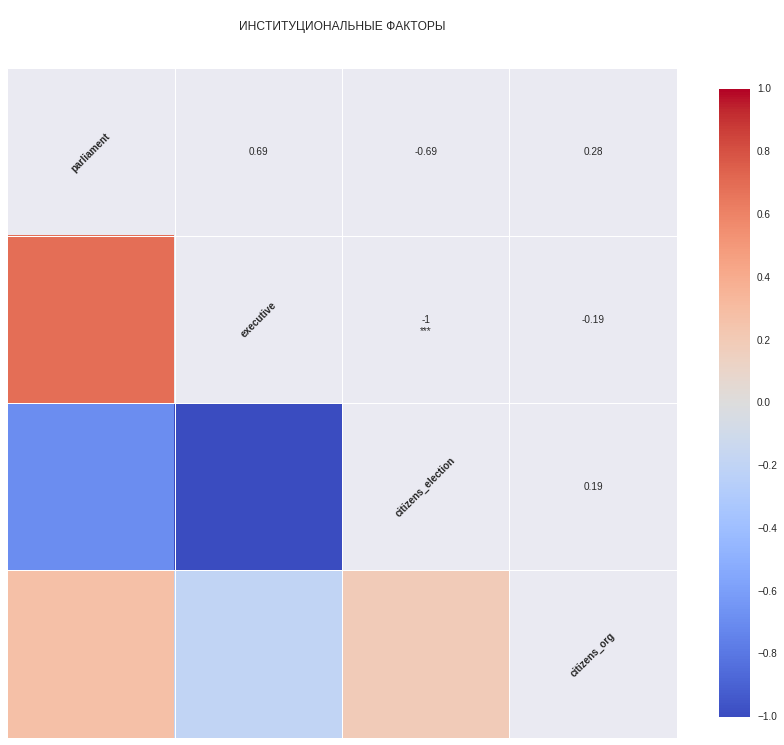

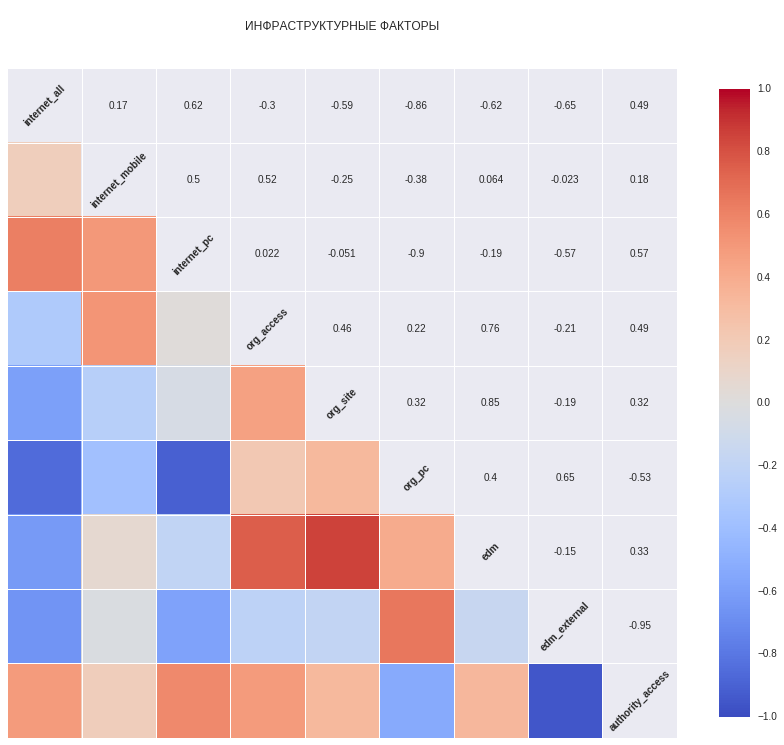

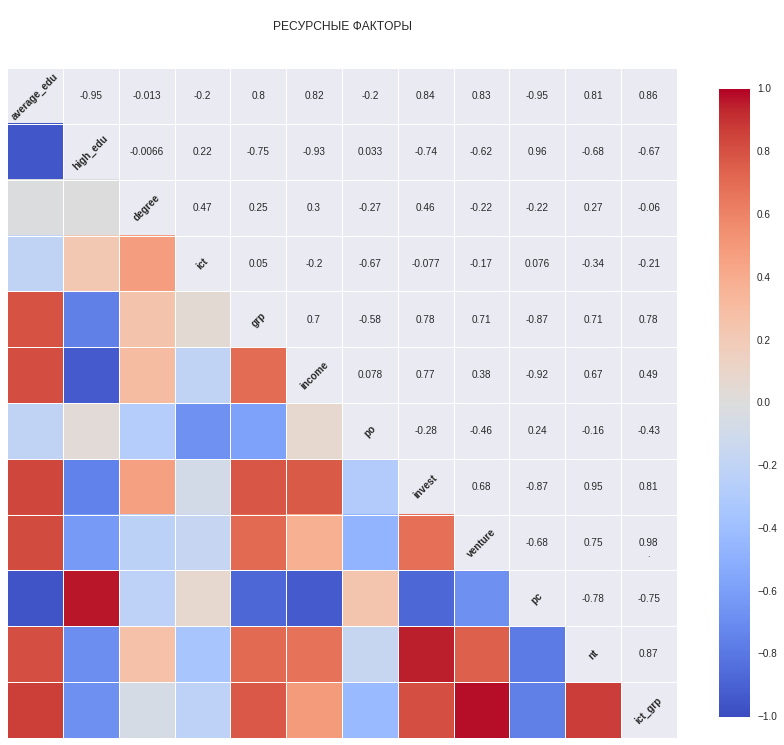

In [8]:
for df in cleared_factors:
    f, ax = plt.subplots(figsize=(15, 15))
    sb.plt.title('\n' + df.df_name.upper())
    sb.corrplot(df)

Некоторые факторы тесно коррелируют друг с другом (> CORRELLATION_LIMIT по модулю). Посмотрим на них поближе.

In [9]:
correlated = {df.df_name: [] for df in cleared_factors}
for df in cleared_factors:
    correlation = df.corr()
    for c1 in df.columns:
        for c2 in df.columns:
            if abs(correlation[c1][c2]) > CORRELLATION_LIMIT and c1 != c2:
                if [c2, c1, correlation[c1][c2]] not in correlated[df.df_name]:
                    correlated[df.df_name].append([c1, c2, correlation[c1][c2]])
for df_name, items in correlated.iteritems():
    if correlated[df_name]: print '\n' + df_name
    for item in items:
        print item


Инфраструктурные факторы
['internet_all', 'org_pc', -0.85607932202748005]
['internet_pc', 'org_pc', -0.89961542306928621]
['org_site', 'edm', 0.85317891025482584]
['edm_external', 'authority_access', -0.94695761888408791]

Ресурсные факторы
['average_edu', 'high_edu', -0.94888363032786294]
['average_edu', 'pc', -0.95473641865299552]
['average_edu', 'ict_grp', 0.86382639050331045]
['high_edu', 'income', -0.92730744749740945]
['high_edu', 'pc', 0.9612544636958853]
['grp', 'pc', -0.86865167438997581]
['income', 'pc', -0.92261616436713123]
['invest', 'pc', -0.87178642594514644]
['invest', 'nt', 0.95006866806240142]
['venture', 'ict_grp', 0.97682432413988096]
['nt', 'ict_grp', 0.86841397525145059]

Институциональные факторы
['executive', 'citizens_election', -0.99996477754971436]


Из каждой группы удалим минимально необходимое для устранения тесных корреляций число факторов.

In [10]:
uncorrelated_factors = []
for df in cleared_factors:
    while correlated[df.df_name]:
        frequencies, removed = {}, []
        for item in correlated[df.df_name]:
            if item[0] in frequencies and item[1] in frequencies:
                frequencies[item[0]] += 1
                frequencies[item[1]] += 1
            elif item[0] in frequencies and item[1] not in frequencies:
                frequencies[item[0]] += 1
                frequencies[item[1]] = 1
            elif item[0] not in frequencies and item[1] in frequencies:
                frequencies[item[0]] = 1
                frequencies[item[1]] += 1
            else:
                frequencies[item[0]] = 1
                frequencies[item[1]] = 1
        most_frequent = max(frequencies, key=lambda i: frequencies[i])
        for item in list(correlated[df.df_name]):
            if most_frequent in item:
                correlated[df.df_name].remove(item)
        name = df.df_name
        df = df.drop(most_frequent, axis=1)
        df.df_name = name
    uncorrelated_factors.append(df)
for df in uncorrelated_factors:
    print '\n' + df.df_name.upper()
    display(df)


ИНСТИТУЦИОНАЛЬНЫЕ ФАКТОРЫ


,parliament,citizens_election,citizens_org
index,,,
vo,47.98,63.8,1.67
ra,34.13,64.4,1.01
ao,44.02,56.2,0.83
rk,36.80,62.0,1.48
kk,27.40,70.8,1.10
ro,40.65,63.8,0.96



ИНФРАСТРУКТУРНЫЕ ФАКТОРЫ


,internet_all,internet_mobile,internet_pc,org_access,edm,edm_external
index,,,,,,
vo,361.6,58.0,101.0,79.2,54.5,47.4
ra,27.8,70.8,104.0,96.2,82.1,44.6
ao,130.2,72.9,108.0,86.0,54.4,51.0
rk,24.0,66.6,89.0,89.4,59.8,51.6
kk,810.9,82.9,113.0,89.2,51.6,44.2
ro,608.3,57.9,105.0,86.0,53.1,43.5



РЕСУРСНЫЕ ФАКТОРЫ


,average_edu,degree,ict,grp,income,po,venture,nt
index,,,,,,,,
vo,65.9,0.015,1.410,278961.2,19055.7,78.0,1,2252.6
ra,63.3,0.016,0.948,174017.6,22054.2,95.3,0,46.9
ao,62.4,0.028,1.320,283591.2,22168.8,82.3,0,213.6
rk,59.2,0.027,1.327,163688.1,12398.4,84.4,0,88.8
kk,68.7,0.031,1.080,330100.2,28787.8,83.8,1,12595.5
ro,63.7,0.035,1.739,235695.9,23354.7,82.4,0,657.6


Для каждого набора по оставшимся факторам отберем наилучшие модели по качеству предсказания бинарных признаков.

In [11]:
target_groups = targets.columns.to_series().groupby(targets.dtypes).groups
categorial_targets = [sublist for k, v in target_groups.iteritems() if k.name not in NUMERIC_TYPES for sublist in v]
print u'Бинарные целевые переменные: \n'
for ct in categorial_targets: print ct
print u'\n\nНепрерывные целевые переменные: \n'
numeric_targets = [nt for nt in set(targets.columns) - set(categorial_targets)]
for nt in numeric_targets: print nt

Бинарные целевые переменные: 

public_discussion


Непрерывные целевые переменные: 

cancelled
tsg


In [ ]:
kf = cross_validation.KFold(len(targets), n_folds=3, shuffle=True)  # используем это разбиение для всех методов
clfs = CLASSIFIERS
c_values, n_trees = np.logspace(-4, 1, 6), np.arange(5, 50, 6) 
best_rez_clf = {tname: {fs.df_name: {'score': -999999} for fs in uncorrelated_factors} for tname in categorial_targets}
for target_name in categorial_targets:
    for factors in uncorrelated_factors:
        target = targets.loc[:, target_name]
        for classifier in clfs:
            for c, n in zip(c_values, n_trees):
#                 start_time = datetime.datetime.now()
                try:
                    clf = classifier(C=c).fit(factors, target)
                except TypeError:
                    clf = classifier(n_estimators=n).fit(factors, target)
                score_list = cross_validation.cross_val_score(clf, factors, target, scoring=SCORING_CLF, cv=kf)
                average_val_score = sum(score_list) / float(len(score_list))
#                 end_time = datetime.datetime.now() - start_time
#                 hours, remainder = divmod(end_time.total_seconds() , 3600)
#                 minutes, seconds = divmod(remainder, 60)
#                 print '%s, %s, var = %.5f, av_score = %.5f, time = %s:%s' % \
#                         (factors.df_name, classifier.__name__, c, average_val_score, minutes, seconds)
                if best_rez_clf[target_name][factors.df_name]['score'] < average_val_score:
                    best_rez_clf[target_name][factors.df_name]['score'] = average_val_score
                    best_rez_clf[target_name][factors.df_name]['var'] = c
                    if classifier.__name__ == 'GradientBoostingClassifier': 
                        best_rez_clf[target_name][factors.df_name]['var'] = n
                    best_rez_clf[target_name][factors.df_name]['clf'] = clf
                    # best_rez_clf[target_name][factors.df_name]['coef'] = clf.coef_
for target in best_rez_clf:
    print target
    for fname in best_rez_clf[target]:
        print '\t' + fname
        for k, v in best_rez_clf[target][fname].iteritems():
            print '\t\t' + k + ': ' + str(v)[:60]
            
    print ''

public_discussion
	Инфраструктурные факторы
		var: 0.1
		clf: LogisticRegression(C=0.10000000000000001, class_weight=None,
		score: -0.333333333333
	Ресурсные факторы
		var: 0.0001
		clf: LogisticRegression(C=0.0001, class_weight=None, dual=False,

		score: -1.0
	Институциональные факторы
		var: 0.01
		clf: LogisticRegression(C=0.01, class_weight=None, dual=False, fi
		score: -0.333333333333



Теперь для каждого набора построим модели для предсказания непрерывных целевых переменных.

In [ ]:
clfs = REGRESSORS
alphas, n_trees = np.logspace(-5, -1, 5), np.arange(5, 50, 6) 
best_rez_rgr = {tname: {fs.df_name: {'score': -999999} for fs in uncorrelated_factors} for tname in numeric_targets}
for target_name in numeric_targets:
    for factors in uncorrelated_factors:
        target = targets.loc[:, target_name]
        for classifier in clfs:
            for a, n in zip(alphas, n_trees):
#                 start_time = datetime.datetime.now()
                try:
                    clf = classifier(alpha=a).fit(factors, target)
                except TypeError:
                    clf = classifier(n_estimators=n).fit(factors, target)
                # r2_score = 1 - residual sum of square / total sum of squares
                score_list = cross_validation.cross_val_score(clf, factors, target, scoring=SCORING_RGR, cv=kf)
                average_val_score = sum(score_list) / float(len(score_list))
#                 end_time = datetime.datetime.now() - start_time
#                 hours, remainder = divmod(end_time.total_seconds() , 3600)
#                 minutes, seconds = divmod(remainder, 60)
#                 print '%s, %s, var = %.5f, av_score = %.5f, time = %s:%s' % \
#                         (factors.df_name, classifier.__name__, c, average_val_score, minutes, seconds)
                if best_rez_rgr[target_name][factors.df_name]['score'] < average_val_score:
                    best_rez_rgr[target_name][factors.df_name]['score'] = average_val_score
                    best_rez_rgr[target_name][factors.df_name]['var'] = a
                    if classifier.__name__ == 'GradientBoostingClassifier': 
                        best_rez_rgr[target_name][factors.df_name]['var'] = n
                    best_rez_rgr[target_name][factors.df_name]['clf'] = clf
                    # best_rez_rgr[target_name][factors.df_name]['coef'] = clf.coef_
for target in best_rez_rgr:
    print target
    for fname in best_rez_rgr[target]:
        print '\t' + fname
        for k, v in best_rez_rgr[target][fname].iteritems():
            print '\t\t' + k + ': ' + str(v)[:60]
            
    print ''

Объединим факторы в один набор и посмотрим на корреляцию.

In [ ]:
all_factors = pd.concat(uncorrelated_factors, axis=1)
print all_factors
f, ax = plt.subplots(figsize=(20, 20))
sb.plt.title(u'Все факторы')
sb.corrplot(all_factors)

In [ ]:
all_correlated = []
correlation = all_factors.corr()
for c1 in all_factors.columns:
    for c2 in all_factors.columns:
        if abs(correlation[c1][c2]) > CORRELLATION_LIMIT and c1 != c2:
            if [c2, c1, correlation[c1][c2]] not in all_correlated:
                all_correlated.append([c1, c2, correlation[c1][c2]])
for item in all_correlated:
    print item

Удалим минимально необходимое для устранения тесных корреляций число факторов.

In [ ]:
all_uncorrelated, removed = [], []
while all_correlated:
    frequencies = {}
    for item in all_correlated:
        if item[0] in frequencies and item[1] in frequencies:
            frequencies[item[0]] += 1
            frequencies[item[1]] += 1
        elif item[0] in frequencies and item[1] not in frequencies:
            frequencies[item[0]] += 1
            frequencies[item[1]] = 1
        elif item[0] not in frequencies and item[1] in frequencies:
            frequencies[item[0]] = 1
            frequencies[item[1]] += 1
        else:
            frequencies[item[0]] = 1
            frequencies[item[1]] = 1
    most_frequent = max(frequencies, key=lambda i: frequencies[i] if i not in removed else 0)
    removed.append(most_frequent)
    for item in all_correlated:
        if most_frequent in item:
            all_correlated.remove(item)
    all_factors = all_factors.drop(most_frequent, axis=1)
display(all_factors)

Число факторов слишком велико для имеющегося количества наблюдений. Снова разобьем данные на три части, соответствующие первоначальным наборам, понизим размерность с помощью метода главных компонент для каждого из наборов до двух.

In [ ]:
resource_columns = [c for c in resource_factors.columns if c in all_factors.columns]
infrastractural_columns = [c for c in infrastructural_factors.columns if c in all_factors.columns]
institutional_columns = [c for c in institutional_factors.columns if c in all_factors.columns]

res = all_factors[resource_columns]
res_scaled = preprocessing.scale(res)
res_pca = decomposition.PCA(n_components=2)
resource_pca = pd.DataFrame(res_pca.fit_transform(res_scaled), 
                            index=resource_factors.index, 
                            columns=['res0', 'res1'])

inf = all_factors[infrastractural_columns]
inf_scaled = preprocessing.scale(inf)
inf_pca = decomposition.PCA(n_components=2)
infrastructural_pca = pd.DataFrame(inf_pca.fit_transform(inf_scaled), 
                                   index=resource_factors.index, 
                                   columns=['inf0', 'inf1'])

ins = all_factors[institutional_columns]
ins_scaled = preprocessing.scale(ins)
ins_pca = decomposition.PCA(n_components=2)
institutional_pca = pd.DataFrame(ins_pca.fit_transform(ins_scaled), 
                                 index=resource_factors.index,
                                 columns=['ins0', 'ins1'])

Вновь объединим наборы и приступим к построению моделей.

In [ ]:
all_factors_pca = pd.concat([resource_pca, infrastructural_pca, institutional_pca], axis=1)
all_factors_pca

In [ ]:
clfs = CLASSIFIERS
c_values, n_trees = np.logspace(-4, 1, 6), np.arange(5, 50, 6) 
pca_rez_clf = {tname: {'score': -999999} for tname in categorial_targets}
for tname in categorial_targets:
    target = targets.loc[:, tname]
    for classifier in clfs:
        for c, n in zip(c_values, n_trees):
#                 start_time = datetime.datetime.now()
            try:
                clf = classifier(C=c).fit(all_factors_pca, target)
            except TypeError:
                clf = classifier(n_estimators=n).fit(all_factors_pca, target)
            score_list = cross_validation.cross_val_score(clf, all_factors_pca, target, scoring=SCORING_CLF, cv=kf)
            average_val_score = sum(score_list) / float(len(score_list))
#                 end_time = datetime.datetime.now() - start_time
#                 hours, remainder = divmod(end_time.total_seconds() , 3600)
#                 minutes, seconds = divmod(remainder, 60)
#                 print '%s, %s, var = %.5f, av_score = %.5f, time = %s:%s' % \
#                         (factors.df_name, classifier.__name__, c, average_val_score, minutes, seconds)
            if pca_rez_clf[tname]['score'] < average_val_score:
                pca_rez_clf[tname]['score'] = average_val_score
                pca_rez_clf[tname]['var'] = c
                if classifier.__name__ == 'GradientBoostingClassifier': 
                    pca_rez_clf[tname]['var'] = n
                pca_rez_clf[tname]['clf'] = clf
                # best_rez_clf[target_name][factors.df_name]['coef'] = clf.coef_
for target in pca_rez_clf:
    print target
    for k, v in pca_rez_clf[target].iteritems():
        print '\t' + k + ': ' + str(v)[:60]
    print ''

In [ ]:
clfs = REGRESSORS
alphas, n_trees = np.logspace(-5, -1, 5), np.arange(5, 50, 6) 
pca_rez_rgr = {tname: {'score': -999999} for tname in numeric_targets}
for target_name in numeric_targets:
    target = targets.loc[:, target_name]
    for classifier in clfs:
        for a, n in zip(alphas, n_trees):
#                 start_time = datetime.datetime.now()
            try:
                clf = classifier(alpha=a).fit(all_factors_pca, target)
            except TypeError:
                clf = classifier(n_estimators=n).fit(all_factors_pca, target)
            # r2_score = 1 - residual sum of square / total sum of squares
            score_list = cross_validation.cross_val_score(clf, all_factors_pca, target, scoring=SCORING_RGR, cv=kf)
            average_val_score = sum(score_list) / float(len(score_list))
#                 end_time = datetime.datetime.now() - start_time
#                 hours, remainder = divmod(end_time.total_seconds() , 3600)
#                 minutes, seconds = divmod(remainder, 60)
#                 print '%s, %s, var = %.5f, av_score = %.5f, time = %s:%s' % \
#                         (factors.df_name, classifier.__name__, c, average_val_score, minutes, seconds)
            if pca_rez_rgr[target_name]['score'] < average_val_score:
                pca_rez_rgr[target_name]['score'] = average_val_score
                if classifier.__name__ == 'Ridge':
                    pca_rez_rgr[target_name]['var'] = a
                if classifier.__name__ == 'GradientBoostingRegressor': 
                    pca_rez_rgr[target_name]['var'] = n
                pca_rez_rgr[target_name]['clf'] = clf
                # best_rez_rgr[target_name][factors.df_name]['coef'] = clf.coef_
for target in pca_rez_rgr:
    print target
    for k, v in pca_rez_rgr[target].iteritems():
        print '\t' + k + ': ' + str(v)[:60]
            
    print ''